# Emulator 

### Import TensorFlow and other libraries

In [375]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [376]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass


In [377]:
import tensorflow as tf

In [378]:
tf.__version__

'2.0.0-rc1'

In [379]:
# To generate GIFs
!pip install -q imageio

In [380]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import tensorflow.keras
import time

from IPython import display

### Load and prepare the dataset

You will use the MNIST dataset to train the generator and the discriminator. The generator will generate handwritten digits resembling the MNIST data.

In [381]:
def load_data():
    path = './mnist.npz'
    with np.load(path) as f:
        x_train, y_train = f['x_train'], f['y_train']
        x_test, y_test = f['x_test'], f['y_test']

    return (x_train, y_train), (x_test, y_test)

In [382]:
def load(split):
    data = np.load('/Users/d567533/FUnOpt/Emulator/mat.npz')
    conditions= data['name1']
    sales= data['name2']

    # Assume that each row of `features` corresponds to the same row as `labels`.
    #assert features.shape[0] == labels.shape[0]

    dataset = tf.data.Dataset.from_tensor_slices((conditions, sales))
    return dataset
    #return (conditions, sales)

In [383]:
train_emulator = load('train')

In [384]:
BUFFER_SIZE = 60000
BATCH_SIZE = 2
EPOCHS = 50
noise_dim = 200
num_examples_to_generate = 16

In [385]:
train_dataset_emulator = train_emulator.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [386]:
print(train_dataset)

<BatchDataset shapes: (None, 28, 28, 1), types: tf.float32>


In [445]:
s=0
for batch in train_dataset_emulator:
     #print(batch[0][0].shape,batch[1][0].shape)
     #print(batch[0].shape)
    print(batch[0].shape)
    s +=1
print(s)

(2, 51, 778, 20)
(2, 51, 778, 20)
(2, 51, 778, 20)
(2, 51, 778, 20)
(2, 51, 778, 20)
(2, 51, 778, 20)
(2, 51, 778, 20)
(2, 51, 778, 20)
(2, 51, 778, 20)
(2, 51, 778, 20)
(2, 51, 778, 20)
(2, 51, 778, 20)
(2, 51, 778, 20)
(2, 51, 778, 20)
(2, 51, 778, 20)
(2, 51, 778, 20)
(2, 51, 778, 20)
(2, 51, 778, 20)
(2, 51, 778, 20)
(2, 51, 778, 20)
(2, 51, 778, 20)
(2, 51, 778, 20)
(2, 51, 778, 20)
(2, 51, 778, 20)
(2, 51, 778, 20)
(2, 51, 778, 20)
(2, 51, 778, 20)
(2, 51, 778, 20)
(2, 51, 778, 20)
(2, 51, 778, 20)
(2, 51, 778, 20)
(2, 51, 778, 20)
(2, 51, 778, 20)
(2, 51, 778, 20)
(2, 51, 778, 20)
(2, 51, 778, 20)
(2, 51, 778, 20)
(2, 51, 778, 20)
(2, 51, 778, 20)
(2, 51, 778, 20)
(2, 51, 778, 20)
(2, 51, 778, 20)
(2, 51, 778, 20)
(2, 51, 778, 20)
(2, 51, 778, 20)
(2, 51, 778, 20)
(2, 51, 778, 20)
(2, 51, 778, 20)
(2, 51, 778, 20)
(2, 51, 778, 20)
(2, 51, 778, 20)
(2, 51, 778, 20)
(2, 51, 778, 20)
(2, 51, 778, 20)
(2, 51, 778, 20)
(2, 51, 778, 20)
(2, 51, 778, 20)
(2, 51, 778, 20)
(2, 51, 778, 2

In [389]:
(train_images, train_labels), (_, _) = load_data()

In [390]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

In [391]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Create the models

Both the generator and discriminator are defined using the [Keras Sequential API](https://www.tensorflow.org/guide/keras#sequential_model).

### The Generator

The generator uses `tf.keras.layers.Conv2DTranspose` (upsampling) layers to produce an image from a seed (random noise). Start with a `Dense` layer that takes this seed as input, then upsample several times until you reach the desired image size of 28x28x1. Notice the `tf.keras.layers.LeakyReLU` activation for each layer, except the output layer which uses tanh.

In [393]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(noise_dim,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)
   
    return model

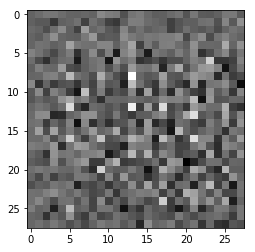

In [394]:
generator = make_generator_model()


noise = tf.random.normal([10, noise_dim])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [395]:
def make_generator_model_emulator():
    
    inputs1 = tf.keras.Input(shape=(51,778,20))
    inputs2 = tf.keras.Input(shape=(noise_dim,))
    
    x = tf.keras.layers.Conv2D(64, (10, 10), strides=(10,10), padding='same')(inputs1)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(500, activation=tf.nn.relu)(x)
    #x = tf.keras.layers.Dense(500, activation=tf.nn.softmax)(x)
    x = tf.keras.layers.Flatten()(x)
    
    y = tf.keras.layers.Dense(500)(inputs2) ##noise input
    y = tf.keras.layers.Flatten()(y)
    x = tf.concat([x,y],-1)

    x = tf.keras.layers.Dense(500, activation=tf.nn.relu)(x)
    x = tf.keras.layers.Dense(778, activation=tf.nn.relu)(x)
    inputs=[inputs1,inputs2]
    outputs = x
    model = tf.keras.Model(inputs=inputs, outputs=[inputs1,x])
  
    return model

Use the (as yet untrained) generator to create an image.

In [396]:

                             
generator_emulator = make_generator_model_emulator()
inputs1 = tf.random.normal([10, 51, 778, 20])
noise = tf.random.normal([10, noise_dim])
generated_sales = generator_emulator([inputs1,noise], training=False)
print(generated_sales)



 

[<tf.Tensor: id=54926, shape=(10, 51, 778, 20), dtype=float32, numpy=
array([[[[-2.41768539e-01, -1.06502163e+00,  3.61111820e-01, ...,
           1.19379818e+00, -3.86802018e-01,  1.08255792e+00],
         [ 4.60734963e-01,  8.43843162e-01, -1.76517057e+00, ...,
           9.75674748e-01,  3.32639903e-01, -2.27553155e-02],
         [ 7.30257332e-01, -8.81289005e-01,  1.02987456e+00, ...,
           6.29250705e-01, -1.76661193e-01, -3.53625387e-01],
         ...,
         [ 2.76755005e-01,  1.66948211e+00,  4.35620844e-01, ...,
          -1.75165430e-01,  1.60718811e+00,  5.54332495e-01],
         [ 7.80849218e-01, -1.05148292e+00, -7.80814588e-01, ...,
           5.67268848e-01, -2.46795607e+00,  2.44677395e-01],
         [-1.97394162e-01,  5.31583965e-01,  9.25596595e-01, ...,
           1.38962817e+00,  5.50833106e-01, -1.86848414e+00]],

        [[-1.35241020e+00,  7.25992978e-01,  7.03613937e-01, ...,
          -9.43220913e-01, -7.14124203e-01,  1.62707686e-01],
         [ 4.05238

In [397]:
print(inputs1.shape,noise.shape)
print(type(inputs1), type(noise))
print(generated_sales[0].shape, generated_sales[1].shape)

(10, 51, 778, 20) (10, 200)
<class 'tensorflow.python.framework.ops.EagerTensor'> <class 'tensorflow.python.framework.ops.EagerTensor'>
(10, 51, 778, 20) (10, 778)


### The Discriminator

The discriminator is a CNN-based image classifier.

In [398]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [399]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor(
[[-6.0747843e-06]
 [-5.3354730e-03]
 [-1.4339420e-03]
 [-2.6597152e-03]
 [-2.7407655e-03]
 [-7.7412935e-04]
 [-2.2947351e-03]
 [-3.7069002e-03]
 [-1.9177597e-03]
 [-3.8601100e-03]], shape=(10, 1), dtype=float32)


In [400]:
def make_discriminator_model_emulator():    
    inputs1 = tf.keras.Input(shape=[51,778,20])
    inputs2 = tf.keras.Input(shape=(778,))

    x = tf.keras.layers.Conv2D(64, (10, 10), strides=(10,10), padding='same')(inputs1)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(500, activation=tf.nn.relu)(x)
    
    x = tf.keras.layers.Flatten()(x)

    y = tf.keras.layers.Dense(500)(inputs2) ##noise input
    y = tf.keras.layers.Flatten()(y)
    x = tf.concat([x,y],-1)

    x = tf.keras.layers.Dense(500, activation=tf.nn.relu)(x)
    x = tf.keras.layers.Dense(1)(x)
    inputs=[inputs1,inputs2]
    model = tf.keras.Model(inputs=inputs, outputs=x)

    return model

In [401]:
discriminator_emulator = make_discriminator_model_emulator()
decision = discriminator_emulator(generated_sales)
print (decision)

tf.Tensor(
[[0.4685685 ]
 [1.273991  ]
 [0.81297666]
 [0.7301884 ]
 [0.56658834]
 [0.17685887]
 [0.18642789]
 [1.2878617 ]
 [1.3100376 ]
 [0.91035044]], shape=(10, 1), dtype=float32)


In [402]:
print(generated_sales[0].shape)

(10, 51, 778, 20)


In [403]:
generated_image.shape
print(type(generated_image))

<class 'tensorflow.python.framework.ops.EagerTensor'>


In [406]:
#train_step(generated_image)

In [407]:
train_step_emulator(generated_sales)

ValueError: in converted code:

    <ipython-input-365-374dcada9fd8>:8 train_step_emulator  *
        generated_sales = generator_emulator([conditional_sales,noise], training=True)
    /usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/engine/base_layer.py:812 __call__
        self.name)
    /usr/local/lib/python3.7/site-packages/tensorflow_core/python/keras/engine/input_spec.py:155 assert_input_compatibility
        ' input tensors. Inputs received: ' + str(inputs))

    ValueError: Layer model_33 expects 2 inputs, but it received 3 input tensors. Inputs received: [<tf.Tensor 'conditional_sales:0' shape=(10, 51, 778, 20) dtype=float32>, <tf.Tensor 'conditional_sales_1:0' shape=(10, 778) dtype=float32>, <tf.Tensor 'random_normal:0' shape=(2, 200) dtype=float32>]


Use the (as yet untrained) discriminator to classify the generated images as real or fake. The model will be trained to output positive values for real images, and negative values for fake images.

## Define the loss and optimizers

Define loss functions and optimizers for both models.


In [408]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Discriminator loss

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [409]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Generator loss
The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, we will compare the discriminators decisions on the generated images to an array of 1s.

In [410]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

The discriminator and the generator optimizers are different since we will train two networks separately.

In [411]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### Save checkpoints
This notebook also demonstrates how to save and restore models, which can be helpful in case a long running training task is interrupted.

In [412]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Define the training loop



In [501]:


# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([BATCH_SIZE, noise_dim])

In [502]:
print(seed.shape)

(2, 200)


The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [464]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [503]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step_emulator(conditional_sales):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_sales = generator_emulator([conditional_sales[0],noise], training=True)

        real_output = discriminator_emulator(conditional_sales, training=True)
        fake_output = discriminator_emulator(generated_sales, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator_emulator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator_emulator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator_emulator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator_emulator.trainable_variables))

In [453]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [504]:
def generate_and_display(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)
    print(predictions)

In [505]:
def train_emulator(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for conditional_sales_batch in dataset:
        train_step_emulator(conditional_sales_batch)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_display(generator_emulator,epoch + 1, [conditional_sales_batch[0],seed])

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_display(generator,epochs, [conditional_sales_batch[0],seed])

**Generate and save images**



In [497]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

## Train the model
Call the `train()` method defined above to train the generator and discriminator simultaneously. Note, training GANs can be tricky. It's important that the generator and discriminator do not overpower each other (e.g., that they train at a similar rate).

At the beginning of the training, the generated images look like random noise. As training progresses, the generated digits will look increasingly real. After about 50 epochs, they resemble MNIST digits. This may take about one minute / epoch with the default settings on Colab.

In [ ]:
%%time
train(train_dataset, EPOCHS)

In [ ]:
%%time
train_emulator(train_dataset_emulator, EPOCHS)

[<tf.Tensor: id=67794, shape=(2, 51, 778, 20), dtype=float32, numpy=
array([[[[ 1.1110002e+09, -1.0000000e+00,  0.0000000e+00, ...,
           2.0000000e+00,  1.8000000e+01,  4.1754000e+04],
         [ 1.1110002e+09, -1.0000000e+00,  2.0000000e+00, ...,
           2.0000000e+00,  1.8000000e+01,  4.1754000e+04],
         [ 1.1110002e+09, -1.0000000e+00,  0.0000000e+00, ...,
           2.0000000e+00,  1.8000000e+01,  4.1754000e+04],
         ...,
         [ 6.1124735e+10, -1.0000000e+00,  0.0000000e+00, ...,
           0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
         [ 6.1124735e+10, -1.0000000e+00,  0.0000000e+00, ...,
           0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
         [ 6.5827619e+10, -1.0000000e+00,  0.0000000e+00, ...,
           0.0000000e+00,  0.0000000e+00,  0.0000000e+00]],

        [[ 1.1110002e+09, -1.0000000e+00,  3.0000000e+00, ...,
           3.0000000e+00,  1.9000000e+01,  4.4712000e+04],
         [ 1.1110002e+09, -1.0000000e+00,  4.0000000e+00, ...

Restore the latest checkpoint.

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))